In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
import math

In [ ]:
li = []
rejdf = pd.read_csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz", index_col=None, header=0, compression='gzip')
rejdf.head()

"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        df = pd.read_csv(os.path.join(dirname, filename), index_col=None, header=0)
        li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
"""

In [ ]:
rejdf.head()

In [ ]:
rejdf.describe()

In [ ]:
import gc
del rejdf
gc.collect()

In [3]:
accdf = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz", index_col=None, header=0, compression='gzip')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
accdf.head()

In [ ]:
accdf.describe()

In [ ]:
accdf.shape

In [ ]:
accdf.columns

In [4]:
loan_df = accdf[["id", "loan_amnt", "int_rate", "installment", "grade", "emp_title", "home_ownership", "annual_inc", "loan_status", "purpose", "title", "dti",
       "delinq_2yrs", "fico_range_low", "fico_range_high", "inq_last_6mths", "mths_since_last_delinq", "revol_bal", "out_prncp", "last_fico_range_high",
       "last_fico_range_low", "application_type", "annual_inc_joint", "dti_joint"]]

We can see the loan amount and installment payed

Grade represents quality of the loan, Lower grade --> Higher interests. This may depend on annual income, emp_title

Loan status tells whther loan is paid off, running, missed or default.

debt to income ration (dti) = lets say your income is 100000 and you are looking for 500,000 loan for home downpayment then dti = 100,000/500,000 = 20%. Typically this ratio is < 40% else its risky loan

FICO score is really key variable and score. High FICO score tells that they may repay the loan. ranges between 300-850.
Typically > 650 loan is provided. for < 650  subprime lending companies provide money but they charge lot of interest.
FICO takes care of lot of parameters like deliquency rates, credit card history, debts, income, your misses in payment etc.

Sometimes, Customers FICO score changes after taking loan. Frequently evaluate customer and update their score in FICO_RANGE_HIGH

Joint applicants like husban-wife can take loan together to purchase something

This is data from peer-peer lending club company. You can ask for loan money till 40K then investors can fund it. They can get more interest for risky loans. This is kind of chit funds.



# Use Case

Population inside data begave differently as a group.

Useful to run marketing segmentation some users are interested in electronics, some are in books. Every one of them need targeted marketing. Segmentation comes into play.

Another is in finance, In case of rejecting the  customer you need to tell why exactly you rejected. You need to tell their dti, annual income. This should also be explained to regulators.

Helps in keeping model simple and explainable. Reduces bias as different simple models are used for different segments.

In [7]:
loan_df.head()

,id,loan_amnt,int_rate,installment,grade,emp_title,home_ownership,annual_inc,loan_status,purpose,...,fico_range_high,inq_last_6mths,mths_since_last_delinq,revol_bal,out_prncp,last_fico_range_high,last_fico_range_low,application_type,annual_inc_joint,dti_joint
0,68407277,3600.0,13.99,123.03,C,leadman,MORTGAGE,55000.0,Fully Paid,debt_consolidation,...,679.0,1.0,30.0,2765.0,0.00,564.0,560.0,Individual,NaN,NaN
1,68355089,24700.0,11.99,820.28,C,Engineer,MORTGAGE,65000.0,Fully Paid,small_business,...,719.0,4.0,6.0,21470.0,0.00,699.0,695.0,Individual,NaN,NaN
2,68341763,20000.0,10.78,432.66,B,truck driver,MORTGAGE,63000.0,Fully Paid,home_improvement,...,699.0,0.0,NaN,7869.0,0.00,704.0,700.0,Joint App,71000.0,13.85
3,66310712,35000.0,14.85,829.90,C,Information Systems Officer,MORTGAGE,110000.0,Current,debt_consolidation,...,789.0,0.0,NaN,7802.0,15897.65,679.0,675.0,Individual,NaN,NaN
4,68476807,10400.0,22.45,289.91,F,Contract Specialist,MORTGAGE,104433.0,Fully Paid,major_purchase,...,699.0,3.0,12.0,21929.0,0.00,704.0,700.0,Individual,NaN,NaN


In [6]:
loan_df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

From plotting fico vs interest rate we can see a trend of lower interest rate for higher fico score. But if we consider many datapoints > 1000. The trend exists but the plot is noisy.

We can subsample from data and consider only some data, but we may miss some important information or a small data with some unique categorical variable. This introduces sampling bias

Use only fully paid, charged off and default to reduce number of data points.

The reason is Late could be people who simply forgot to pay the installment as they missed the reminder or forgot.

Charged Off - Customer has definetly turned bad and their assets have been auctioned off and taken care.

Default on the brink of charged off, may turn bad

In [8]:
loan_int_df = loan_df[loan_df["loan_status"] != "Current"]
loan_int_df = loan_int_df[loan_df["loan_status"] != "Late (31-120 days)"]
loan_int_df = loan_int_df[loan_df["loan_status"] != "In Grace Period"]
loan_int_df = loan_int_df[loan_df["loan_status"] != "Late (16-30 days)"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [9]:
loan_int_df["loan_status"] = loan_int_df["loan_status"].replace("Charged Off", "Default")
loan_int_df["loan_status"] = loan_int_df["loan_status"].replace("Does not meet the credit policy. Status:Charged Off", "Default")
loan_int_df["loan_status"] = loan_int_df["loan_status"].replace("Does not meet the credit policy. Status:Fully Paid", "Good")
loan_int_df["loan_status"] = loan_int_df["loan_status"].replace("Fully Paid", "Good")

In [10]:
loan_int_df["loan_status"].value_counts()

Good       1078739
Default     269360
Name: loan_status, dtype: int64

In [11]:
loan_int_df.groupby("loan_status").agg({"last_fico_range_high": "mean"})

,last_fico_range_high
loan_status,
Default,568.572824
Good,704.384444


We can see that customers with typicall high fico score tend to fully pay their loans whereas people with fico score < 600 may not pay their loans. However this may not be true in all cases some variations do exist

In [12]:
loan_int_df["fico_range_low"].min(), loan_int_df["fico_range_low"].max()

(610.0, 845.0)

As we can see with column "last_fico_range_low", for some customers this is not captured and mentioned as zero.
Use a lambda functio and set it to minimum fico_range_low score 

In [13]:
loan_int_df["last_fico_range_low"].min(), loan_int_df["last_fico_range_low"].max()

(0.0, 845.0)

last_fico_range_low is usually flexible score that varies during tenure of the loan . Used to track customer after loand is given and important for credit modelling

In [14]:
loan_int_df["last_fico_range_low"] = loan_int_df.apply(lambda x: x["fico_range_low"] if x["last_fico_range_low"] == 0.0 
                                                       else x["last_fico_range_low"], axis = 1)

In [17]:
loan_int_df["last_fico_range_low"].value_counts().sort_index()

500.0     7663
505.0     8268
510.0     9391
515.0     9483
520.0    10854
         ...  
825.0     3537
830.0     2123
835.0     1047
840.0      570
845.0      255
Name: last_fico_range_low, Length: 70, dtype: int64

Here we use pandas cut function to segment into 5 buckets, We can ssign labels to each of these buckets

In [16]:
pd.cut(loan_int_df["last_fico_range_low"], 5)

0          (499.655, 569.0]
1            (638.0, 707.0]
2            (638.0, 707.0]
4            (638.0, 707.0]
5            (707.0, 776.0]
                 ...       
2260691      (707.0, 776.0]
2260692      (638.0, 707.0]
2260697      (569.0, 638.0]
2260699                 NaN
2260700                 NaN
Name: last_fico_range_low, Length: 1348132, dtype: category
Categories (5, interval[float64]): [(499.655, 569.0] < (569.0, 638.0] < (638.0, 707.0] < (707.0, 776.0] < (776.0, 845.0]]

Assign to 5 buckets

In [18]:
loan_int_df["fico_buckets"] = pd.cut(loan_int_df["last_fico_range_low"], 5 , labels=["High Risky", "Risky", "Low Risky", "Good", "Excellent"])

In [19]:
loan_int_df.head()

,id,loan_amnt,int_rate,installment,grade,emp_title,home_ownership,annual_inc,loan_status,purpose,...,inq_last_6mths,mths_since_last_delinq,revol_bal,out_prncp,last_fico_range_high,last_fico_range_low,application_type,annual_inc_joint,dti_joint,fico_buckets
0,68407277,3600.0,13.99,123.03,C,leadman,MORTGAGE,55000.0,Good,debt_consolidation,...,1.0,30.0,2765.0,0.0,564.0,560.0,Individual,NaN,NaN,High Risky
1,68355089,24700.0,11.99,820.28,C,Engineer,MORTGAGE,65000.0,Good,small_business,...,4.0,6.0,21470.0,0.0,699.0,695.0,Individual,NaN,NaN,Low Risky
2,68341763,20000.0,10.78,432.66,B,truck driver,MORTGAGE,63000.0,Good,home_improvement,...,0.0,NaN,7869.0,0.0,704.0,700.0,Joint App,71000.0,13.85,Low Risky
4,68476807,10400.0,22.45,289.91,F,Contract Specialist,MORTGAGE,104433.0,Good,major_purchase,...,3.0,12.0,21929.0,0.0,704.0,700.0,Individual,NaN,NaN,Low Risky
5,68426831,11950.0,13.44,405.18,C,Veterinary Tecnician,RENT,34000.0,Good,debt_consolidation,...,0.0,NaN,8822.0,0.0,759.0,755.0,Individual,NaN,NaN,Good


In each bucket what is the type and distribution of customer you get. Use group by aggregates

In [20]:
loan_status_df = loan_int_df[["loan_status", "fico_buckets"]].groupby(["loan_status", "fico_buckets"]).agg({"fico_buckets": "count"})

In [21]:
loan_status_df.head()

fico_buckets
loan_status fico_buckets              
Default     High Risky          122708
            Risky                87836
            Low Risky            50520
            Good                  7527
            Excellent              769

In [22]:
loan_status_df.rename({"fico_buckets": "count"}, axis = "columns").reset_index()

,loan_status,fico_buckets,count
0,Default,High Risky,122708
1,Default,Risky,87836
2,Default,Low Risky,50520
3,Default,Good,7527
4,Default,Excellent,769
5,Good,High Risky,37156
6,Good,Risky,94645
7,Good,Low Risky,437401
8,Good,Good,403491
9,Good,Excellent,106046


If customers are high risky then they are more probable to default

Similarly good and excellent customers never default

Why are we doing this?

* At segment level simple logistic regression or other simple models can be applied. This could be less complex than decision trees.
* This helps to provide explainability at instance level.
* For each predicted instance we can go back to our model and check what are the parameters and exact reason of why it is giving this output

<AxesSubplot:xlabel='fico_buckets', ylabel='count'>

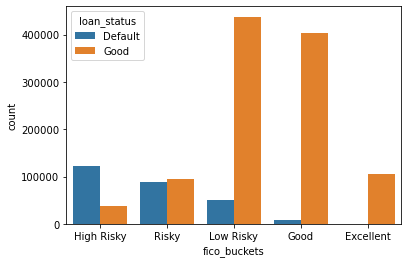

In [24]:
sns.barplot(x="fico_buckets", y="count",hue="loan_status", data=loan_status_df.rename({"fico_buckets": "count"}, axis = "columns").reset_index())

Do for other columns as well, Also use Qcut(qualtile cut) that takes data distribution int account and doesnt distribute into equal sized buckets.

Interest rate is right skewed qcut would help to solve this

In [26]:
pd.qcut(loan_int_df["int_rate"], 5)

0          (13.98, 16.99]
1          (11.53, 13.98]
2            (8.9, 11.53]
4          (16.99, 30.99]
5          (11.53, 13.98]
                ...      
2260691    (13.98, 16.99]
2260692    (11.53, 13.98]
2260697    (13.98, 16.99]
2260699               NaN
2260700               NaN
Name: int_rate, Length: 1348132, dtype: category
Categories (5, interval[float64]): [(5.308999999999999, 8.9] < (8.9, 11.53] < (11.53, 13.98] < (13.98, 16.99] < (16.99, 30.99]]

In [28]:
loan_int_df["rate_buckets"] = pd.qcut(loan_int_df["int_rate"], 5, labels=["Low", "Medium", "High", "Very High", "ForgetIt"])

In [29]:
loan_int_df.head()

,id,loan_amnt,int_rate,installment,grade,emp_title,home_ownership,annual_inc,loan_status,purpose,...,mths_since_last_delinq,revol_bal,out_prncp,last_fico_range_high,last_fico_range_low,application_type,annual_inc_joint,dti_joint,fico_buckets,rate_buckets
0,68407277,3600.0,13.99,123.03,C,leadman,MORTGAGE,55000.0,Good,debt_consolidation,...,30.0,2765.0,0.0,564.0,560.0,Individual,NaN,NaN,High Risky,Very High
1,68355089,24700.0,11.99,820.28,C,Engineer,MORTGAGE,65000.0,Good,small_business,...,6.0,21470.0,0.0,699.0,695.0,Individual,NaN,NaN,Low Risky,High
2,68341763,20000.0,10.78,432.66,B,truck driver,MORTGAGE,63000.0,Good,home_improvement,...,NaN,7869.0,0.0,704.0,700.0,Joint App,71000.0,13.85,Low Risky,Medium
4,68476807,10400.0,22.45,289.91,F,Contract Specialist,MORTGAGE,104433.0,Good,major_purchase,...,12.0,21929.0,0.0,704.0,700.0,Individual,NaN,NaN,Low Risky,ForgetIt
5,68426831,11950.0,13.44,405.18,C,Veterinary Tecnician,RENT,34000.0,Good,debt_consolidation,...,NaN,8822.0,0.0,759.0,755.0,Individual,NaN,NaN,Good,High


We can see that buckets have almost same counts, this is due to qcut

In [30]:
loan_int_df["rate_buckets"].value_counts()

Very High    274197
Medium       273140
Low          271521
High         264838
ForgetIt     264403
Name: rate_buckets, dtype: int64

In [31]:
loan_int_df[["loan_status", "fico_buckets", "rate_buckets"]].groupby(["fico_buckets", "rate_buckets"]).agg({"loan_status": "count"})

loan_status
fico_buckets rate_buckets             
High Risky   Low                 10419
             Medium              23066
             High                31486
             Very High           41925
             ForgetIt            52968
Risky        Low                 15873
             Medium              29009
             High                37854
             Very High           46096
             ForgetIt            53649
Low Risky    Low                 68141
             Medium             101334
             High               104026
             Very High          109752
             ForgetIt           104668
Good         Low                122471
             Medium              98166
             High                77098
             Very High           66175
             ForgetIt            47108
Excellent    Low                 54617
             Medium              21565
             High                14374
             Very High           10249
             ForgetIt             6010

In [32]:
pd.crosstab(index=loan_int_df["fico_buckets"], columns=loan_int_df["rate_buckets"], margins=True)

rate_buckets,Low,Medium,High,Very High,ForgetIt,All
fico_buckets,,,,,,
High Risky,10419,23066,31486,41925,52968,159864
Risky,15873,29009,37854,46096,53649,182481
Low Risky,68141,101334,104026,109752,104668,487921
Good,122471,98166,77098,66175,47108,411018
Excellent,54617,21565,14374,10249,6010,106815
All,271521,273140,264838,274197,264403,1348099


In [33]:
pd.crosstab(index=loan_int_df["fico_buckets"], columns=loan_int_df["rate_buckets"], margins=True).apply(lambda x: x/x.sum(), axis=1)

rate_buckets,Low,Medium,High,Very High,ForgetIt,All
fico_buckets,,,,,,
High Risky,0.032587,0.072143,0.098477,0.131127,0.165666,0.5
Risky,0.043492,0.079485,0.103720,0.126304,0.146999,0.5
Low Risky,0.069828,0.103843,0.106601,0.112469,0.107259,0.5
Good,0.148985,0.119418,0.093789,0.080501,0.057306,0.5
Excellent,0.255662,0.100946,0.067285,0.047975,0.028133,0.5
All,0.100705,0.101306,0.098226,0.101698,0.098065,0.5


In [34]:
fico_rate_ct = pd.crosstab(index=loan_int_df["fico_buckets"], columns=loan_int_df["rate_buckets"])

<AxesSubplot:xlabel='fico_buckets'>

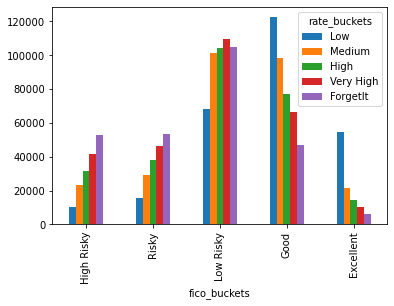

In [40]:
fico_rate_ct.plot.bar()

We can see from chi squared test that it has high score and statistically significant with p < 0.05

In [41]:

(chi2, p, dof,_) = stats.chi2_contingency([fico_rate_ct.iloc[0].values,fico_rate_ct.iloc[1].values, fico_rate_ct.iloc[2].values, fico_rate_ct.iloc[3].values, fico_rate_ct.iloc[4].values])
print("chi2: ", chi2)
print("p: ", p )
print("dof: ", dof)

chi2:  180911.32321320334
p:  0.0
dof:  16


We can see that there are sup prime customers at fico score of 500

In [42]:
(loan_int_df["last_fico_range_low"].min(), loan_int_df["last_fico_range_low"].max())

(500.0, 845.0)

Looks like there are some null values in last_fico_range, set them to minimum 500.0

In [43]:
loan_int_df["last_fico_range_low"].isnull().sum()

33

In [44]:
loan_int_df["last_fico_range_low"] = loan_int_df["last_fico_range_low"].fillna(500.0)

The fico score is a continous score and can cause problems . Bucket it into 10s category. like 500-510, 510-520 etc

In [45]:
loan_int_df["fico_score"] = loan_int_df["last_fico_range_low"].apply(lambda x: int(math.ceil(x/10)) * 10)

In [46]:
loan_int_df.isnull().sum()

id                              0
loan_amnt                      33
int_rate                       33
installment                    33
grade                          33
emp_title                   85983
home_ownership                 33
annual_inc                     37
loan_status                    33
purpose                        33
title                       16694
dti                           407
delinq_2yrs                    62
fico_range_low                 33
fico_range_high                33
inq_last_6mths                 63
mths_since_last_delinq     679993
revol_bal                      33
out_prncp                      33
last_fico_range_high           33
last_fico_range_low             0
application_type               33
annual_inc_joint          1322326
dti_joint                 1322329
fico_buckets                   33
rate_buckets                   33
fico_score                      0
dtype: int64

Use segmentation peice wise linear regression

In [49]:
default_df=pd.DataFrame(loan_int_df[loan_int_df['loan_status']=='Default']['fico_score'].value_counts())

In [50]:
default_df=default_df.reset_index()

In [51]:
default_df.columns = ['fico_score','default_total']

In [52]:
default_df.head()

,fico_score,default_total
0,550,19710
1,540,19599
2,560,19007
3,570,17940
4,530,17844


We can see strong negative corelation as expected. People with higher fico score have less chance to default

In [53]:
default_df[["fico_score", "default_total"]].corr(method="spearman")

,fico_score,default_total
fico_score,1.00000,-0.93565
default_total,-0.93565,1.00000


Use segmentation

In [57]:
#!pip install pwlf
import pwlf

ModuleNotFoundError: No module named 'pwlf'

Do peice wise linear fit

In real world multiple variables will be present, first get the bucket and filt model.

For multiple variables use decision trees to fit the model, use pwlf just to put them to bucket

In [ ]:
pwlf_df = pwlf.PiecewiseLinFit(default_df["fico_score"], default_df["default_total"])

In [ ]:
pwise_model = pwlf_df.fit(4)

In [ ]:
pwlf_df.fit_breaks

In [ ]:
pwlf_df.slopes

In [ ]:
pwlf_df.intercepts

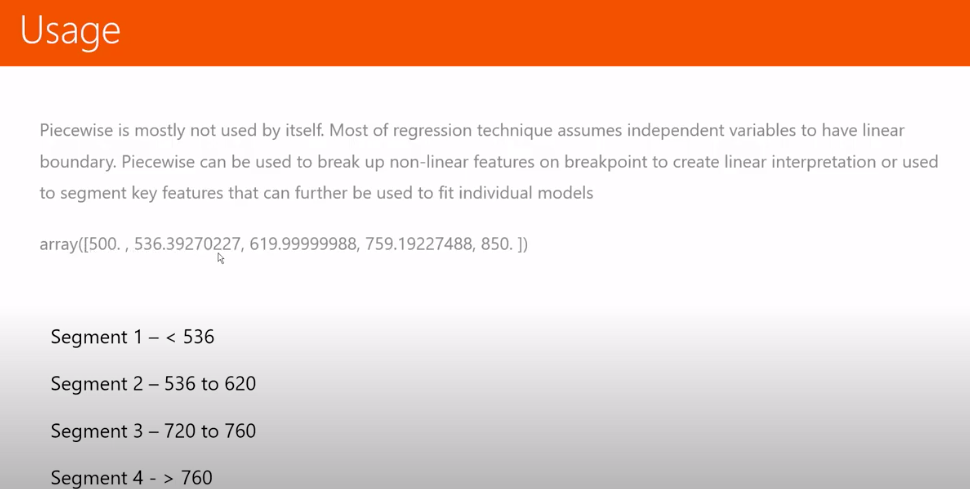

In [ ]:
yhat_piecewise = pwlf.predict(loan_df["fico_score"])